[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/systemslibrarian/Enterprise-Customer-Segmentation-Analytics/blob/main/Enterprise_Customer_Segmentation_Analytics.ipynb)

# **Enterprise Customer Segmentation & Analytics**
*From raw data to actionable customer intelligence — powered by SQL & Python*

**Purpose of this Notebook**  
This notebook is designed to **demonstrate advanced SQL techniques for enterprise-grade customer analytics**. You’ll learn how to clean and prepare data, optimize queries, and apply powerful functions like CTEs, window functions, LAG/LEAD, and multi-dimensional segmentation. You will also build interactive dashboards, generate predictive customer insights, and see how to package and schedule your work for production environments.

📈 **Key Business Questions**
1. **Who are our customers?** — We’ll clean our data and create foundational segments based on spending.
2. **How do they behave?** — We’ll analyze purchase frequency, product variety, and identify our most loyal VIPs.
3. **Who should we focus on next?** — We’ll build a predictive segment to find high‑potential customers for targeted campaigns.


## Table of Contents
  - [Table of Contents](#table-of-contents)
  - [✅ Calculating Time Gaps — LAG & LEAD](#calculating-time-gaps-lag-lead)
  - [✅ Mastering Joins — INNER vs LEFT](#mastering-joins-inner-vs-left)
  - [🚀 Advanced Aggregations — GROUPING SETS (Simulated)](#advanced-aggregations-grouping-sets-simulated)
- [⚙️ Setup & Seeding](#setup-seeding)
- [✅ COALESCE — Plan B for NULLs](#coalesce-plan-b-for-nulls)
- [✅ Data Cleaning First — `TRIM` & `LOWER`](#data-cleaning-first-trim-lower)
- [✅ CASE WHEN — Simple Segmentation](#case-when-simple-segmentation)
- [✅ GROUP_CONCAT — Aggregating Strings](#group_concat-aggregating-strings)
- [✅ strftime — Bucketing by Month](#strftime-bucketing-by-month)
- [✅ Window Functions — Top‑N per Group](#window-functions-topn-per-group)
- [✍️ Your Turn: Oldest Purchases](#your-turn-oldest-purchases)
- [✅ Handling Ties — `RANK` vs `DENSE_RANK`](#handling-ties-rank-vs-dense_rank)
  - [🎯 Toy Dataset — Visualizing Ties for RANK() vs DENSE_RANK()](#toy-dataset-visualizing-ties-for-rank-vs-dense_rank)
- [✅ Nested CASE — Multi-dimensional Segmentation](#nested-case-multi-dimensional-segmentation)
  - [Insightful Visualization: Spend vs. Breadth](#insightful-visualization-spend-vs-breadth)
- [🚀 Performance Tuning — `EXPLAIN QUERY PLAN`](#performance-tuning-explain-query-plan)
- [🚀 Capstone — The Final Report](#capstone-the-final-report)
  - [🧪 Data Quality & Validation — Constraints + Programmatic Checks](#data-quality-validation-constraints-programmatic-checks)
  - [🏆 Your Final Challenge: Identify At‑Risk VIPs](#your-final-challenge-identify-atrisk-vips)
  - [Option A — If your capstone already has segments](#option-a-if-your-capstone-already-has-segments)
  - [Option B — Fallback segmentation by purchase count (runnable)](#option-b-fallback-segmentation-by-purchase-count-runnable)

In [ ]:
# 🎨 Global visual style
import seaborn as sns
sns.set_theme(style='whitegrid', palette='crest')  # cohesive blue/green palette


### 🎨 Visualization Guidelines
- Use **full-sentence titles** (e.g., *“Distribution of Customers by Segment — Big Spenders are a small but valuable group.”*)
- Add **subtitles/annotations** to highlight the key takeaway.
- Keep axes and legends concise; prefer units in labels.
- Reuse this theme for consistency across all charts.

In [ ]:
# 🧰 Import reusable analytics toolkit
import sys
sys.path.append('/mnt/data')  # so the notebook can import the toolkit file
from analytics_toolkit import get_db_connection, find_potential_vips

# Example usage (requires seeded tables):
try:
    conn = get_db_connection(':memory:')  # replace with your DB if needed
    # display(find_potential_vips(conn, min_products=3, max_avg_days=30))
except Exception as e:
    print('Toolkit imported. Run after data setup to execute examples.')


## 📈 Key Business Questions
This notebook uses customer data to answer three core questions:

1. **Who are our customers?**  
   We clean the data and create foundational segments based on spending.

2. **How do they behave?**  
   We analyze purchase frequency, product variety, and identify our most loyal VIPs.

3. **Who should we focus on next?**  
   We conclude by building a predictive segment to find customers with high potential, giving marketing an actionable list for future campaigns.


**Goal / How it works**

- **Goal:** Assign mutually exclusive, business-meaningful segments.
- **How it works:** Ordered `CASE WHEN` blocks; first match wins; final `ELSE` for coverage.

**Executive Summary:**

We move beyond simple spend totals to identify our true power users. By combining purchase value with product variety and frequency, we define a “VIP Multi‑Buyer” segment — a core group of customers who purchase broadly and often. These segments turn raw metrics into labels that product and marketing can act on.

### ✅ Calculating Time Gaps — LAG & LEAD
**Goal:** For each customer, calculate the number of days between consecutive purchases.

**Why this matters:** Repurchase cadence is a leading indicator of engagement and churn.
- `LAG(col, 1)` peeks at the *previous* row within each partition.
- `LEAD(col, 1)` peeks at the *next* row within each partition.
- Use `julianday()` to turn dates into numbers for easy subtraction in SQLite.


**Goal / How it works**

- **Goal:** Measure cadence between events.
- **How it works:** `LAG()` to get the prior timestamp per partition; `julianday()` to compute diffs.

**Why this matters (Business Question):**

_How often do our customers return? Are they making purchases every week, month, or year?_ Understanding the cadence between purchases helps us track loyalty, predict churn, and time campaigns.

In [ ]:
# 📈 Time between purchases per customer using LAG
q('''
WITH ordered_purchases AS (
  SELECT
    customer_id,
    purchase_ts,
    LAG(purchase_ts, 1) OVER (
      PARTITION BY customer_id
      ORDER BY purchase_ts
    ) AS prev_purchase_ts
  FROM purchases
)
SELECT
  customer_id,
  prev_purchase_ts,
  purchase_ts,
  ROUND(julianday(purchase_ts) - julianday(prev_purchase_ts), 2) AS days_between
FROM ordered_purchases
WHERE prev_purchase_ts IS NOT NULL
ORDER BY customer_id, purchase_ts;
''')


### ✅ Mastering Joins — INNER vs LEFT
**INNER JOIN** keeps only rows that match in both tables.
**LEFT JOIN** keeps *all* rows from the left table and fills with `NULL` when there is no match on the right.

> **Pro tip:** SQLite has no `FULL OUTER JOIN`, but you can simulate it using `LEFT JOIN` in both directions with `UNION`.


In [ ]:
# 🔗 Compare INNER vs LEFT join outcomes on customers ↔ purchases
print('INNER JOIN: only customers who have purchases')
q('''
SELECT c.id AS customer_id, c.name, p.id AS purchase_id
FROM customers c
INNER JOIN purchases p ON p.customer_id = c.id
ORDER BY c.id, p.id
''')

print('LEFT JOIN: all customers, showing NULL when no purchase exists')
q('''
SELECT c.id AS customer_id, c.name, p.id AS purchase_id
FROM customers c
LEFT JOIN purchases p ON p.customer_id = c.id
ORDER BY c.id, p.id
''')

# (Advanced) FULL OUTER JOIN simulation example (shape, not executed here):
# SELECT * FROM customers c LEFT JOIN purchases p ON ...
# UNION
# SELECT * FROM customers c RIGHT JOIN purchases p ON ...  -- SQLite lacks RIGHT JOIN
# In SQLite specifically, simulate RIGHT JOIN by flipping tables and using LEFT JOIN.


### 🚀 Advanced Aggregations — GROUPING SETS (Simulated)
Some databases support `GROUPING SETS / ROLLUP / CUBE` to compute multiple subtotal levels in one query.
SQLite doesn’t implement these keywords directly, but you can **simulate** them with `UNION ALL`.

**Goal:** Per‑customer purchase counts *plus* a grand total, in one result set.


**Goal / How it works**

- **Goal:** Multi-level totals in one result.
- **How it works:** Simulate `GROUPING SETS` in SQLite with `UNION ALL` blocks.

**Why this matters (Business Question):**

_Can we create one report that shows both individual customer purchase counts and a grand total for the entire business?_ Simulating GROUPING SETS lets us produce multi‑level summaries efficiently in SQLite.

In [ ]:
# 🧮 Simulate GROUPING SETS using UNION ALL in SQLite
q('''
-- Per-customer counts
SELECT c.name AS level_key, COUNT(p.id) AS total_purchases, 'customer' AS level
FROM customers c
LEFT JOIN purchases p ON p.customer_id = c.id
GROUP BY c.name

UNION ALL

-- Grand total across all customers
SELECT 'All Customers' AS level_key, COUNT(p.id) AS total_purchases, 'grand_total' AS level
FROM customers c
LEFT JOIN purchases p ON p.customer_id = c.id
ORDER BY level, level_key;
''')


> **Tip:** In nested CASE blocks, order your WHEN clauses from most‑specific to least‑specific.
>
> Add a final `ELSE` to capture uncategorized rows, and run a QA query (COUNT by segment) to confirm exclusivity and coverage.

<a id="setup"></a>

## ⚙️ Setup & Seeding


Run these once to make the notebook **re-runnable** and **persistent** in Colab.

In [ ]:
# 📈 Runs a SQL query and captures the result into a DataFrame.
# 📊 Visualizes results with matplotlib.

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
pd.set_option("display.max_columns", 50); pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid")

# Persistence: file DB by default so data survives reruns
PERSIST_DB = True
DB_PATH = 'sqlite_demo_enhanced.db'
conn = sqlite3.connect(DB_PATH if PERSIST_DB else ':memory:')
cur = conn.cursor()

def q(sql, params=None):
    """Run SQL and return a DataFrame."""
    return pd.read_sql_query(sql, conn, params=params)

def table_count(name):
    try:
        return pd.read_sql_query(f"SELECT COUNT(*) AS c FROM {name};", conn)['c'].iloc[0]
    except Exception:
        return None

def seed_if_needed():
    cur.executescript('''-- 🧭 Annotated query.

DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS transactions;
DROP TABLE IF EXISTS purchases;
DROP TABLE IF EXISTS orders;
DROP TABLE IF EXISTS user_activities;
CREATE TABLE customers (id INTEGER PRIMARY KEY, name TEXT, email TEXT, backup_email TEXT);
CREATE TABLE transactions (id INTEGER PRIMARY KEY, customer_id INTEGER, purchase_amount REAL);
CREATE TABLE purchases (id INTEGER PRIMARY KEY, customer_id INTEGER, product TEXT, purchase_ts TEXT);
CREATE TABLE orders (id INTEGER PRIMARY KEY, order_date TEXT);
CREATE TABLE user_activities (id INTEGER PRIMARY KEY, user_id INTEGER, activity_date TEXT);
''')
    if (table_count('customers') or 0) == 0:
        cur.executemany("INSERT INTO customers (id,name,email,backup_email) VALUES (?,?,?,?)", [
            (1,'Ada',None,'ada.alt@example.com'),
            (2,'Grace','grace@example.com',None),
            (3,'Linus',None,None),
            (4,'Margaret','  margaret@example.com  ','margaret.alt@example.com')
        ])
    if (table_count('transactions') or 0) == 0:
        cur.executemany("INSERT INTO transactions (customer_id,purchase_amount) VALUES (?,?)", [
            (1,600.00),(2,250.25),(3,50.00),(4,1200.00)
        ])
    if (table_count('purchases') or 0) == 0:
        cur.executemany("INSERT INTO purchases (customer_id,product,purchase_ts) VALUES (?,?,?)", [
            (1,'Laptop','2023-01-02'),
            (1,'Mouse','2023-01-10'),
            (1,'USB-C Hub','2023-02-01'),
            (2,'Tablet','2023-01-05'),
            (2,'Case','2023-02-08'),
            (3,'Book','2023-01-07'),
            (3,'Pen','2023-01-09'),
            (3,'Notebook','2023-03-01'),
            (4,'Server','2023-02-15'),
            (4,'Enterprise Support','2023-03-12')
        ])
    if (table_count('orders') or 0) == 0:
        cur.executemany("INSERT INTO orders (order_date) VALUES (?)", [
            ('2023-01-15',),('2023-01-20',),
            ('2023-02-10',),('2023-02-25',),
            ('2023-03-02',),('2023-03-31',)
        ])
    if (table_count('user_activities') or 0) == 0:
        cur.executemany("INSERT INTO user_activities (user_id,activity_date) VALUES (?,?)", [
            (1,'2023-08-01'),(1,'2023-08-05'),
            (2,'2023-08-03'),(2,'2023-08-04'),
            (3,'2023-08-02')
        ])
    conn.commit()

seed_if_needed()
# Verify the row counts in all created tables
q("""-- 🧭 Annotated query.
SELECT 'customers' AS table_name, COUNT(*) AS rows FROM -- source tables/CTEs customers
UNION ALL SELECT 'transactions', COUNT(*) FROM -- source tables/CTEs transactions
UNION ALL SELECT 'purchases', COUNT(*) FROM -- source tables/CTEs purchases
UNION ALL SELECT 'orders', COUNT(*) FROM -- source tables/CTEs orders
UNION ALL SELECT 'user_activities', COUNT(*) FROM -- source tables/CTEs user_activities;""")

,table_name,rows
0,customers,4
1,transactions,4
2,purchases,10
3,orders,6
4,user_activities,5


#### 🧩 Interpreting the Nested CASE Segmentation
- **What you’re seeing:** each row assigned to exactly one category based on ordered `WHEN` conditions.
- **Ordering matters:** most‑specific conditions should be listed first; the first match wins and stops evaluation.
- **Coverage:** use an `ELSE` bucket for uncategorized rows and audit with a `COUNT(*) BY segment` query to ensure coverage.
- **Edge cases:** ties around numeric thresholds can flip categories—consider using `>=` vs `>` consistently.
- **Business readout:** the segments translate raw metrics (spend/frequency/recency) into analyst‑friendly labels for dashboards and experiments.

<a id="coalesce"></a>

## ✅ COALESCE — Plan B for NULLs


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Pick the **best email** per customer: primary → backup → default.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>`COALESCE(a,b,...)` returns the **first non-NULL**. But beware: **'' (empty string) is not NULL**.
</div>


#### 🔍 Deep Dive

- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

In [ ]:

# Pitfall: COALESCE('' , backup) returns '' (bad)
cur.execute("INSERT OR IGNORE INTO customers (id, name, email, backup_email) VALUES (5, 'Dennis', '', 'dennis.alt@example.com')")
conn.commit()
# This query demonstrates the problem.
# COALESCE sees the empty string '' in the 'email' column and stops, returning it.
# It never checks the 'backup_email' column.
q("""-- 🧭 Annotated query.
SELECT id, name,
       COALESCE(email, backup_email) AS broken_email
FROM -- source tables/CTEs customers
WHERE -- pre-aggregation filters id = 5;""")


,id,name,broken_email
0,5,Dennis,



<div style="padding:12px 14px;border-left:6px solid #ef6c00;background:#fff3e0;border-radius:8px;margin:10px 0;">
<b>⚠️ Gotcha</b><br>`COALESCE('', backup)` returns `''`. Normalize blanks to NULL first.
</div>


#### 🔍 Deep Dive

- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

In [ ]:

# Fix: normalize blank -> NULL, then COALESCE
# NULLIF(email, '') says: "If email is an empty string, treat it as NULL. Otherwise, use its value."
# COALESCE then correctly skips the NULL and moves to the backup_email.
q("""-- 🧭 Annotated query.
SELECT id, name,
       COALESCE(NULLIF(email, ''), backup_email, 'noemail@example.com') AS best_email
FROM -- source tables/CTEs customers
WHERE -- pre-aggregation filters id = 5;""")


<a id="cleaning"></a>

## ✅ Data Cleaning First — `TRIM` & `LOWER`

<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Ensure data is **consistent and clean** before analysis. Remove leading/trailing spaces and standardize case.
</div>

<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>Use `TRIM()` to remove whitespace and `LOWER()` to standardize text to lowercase. This prevents errors in joins and aggregations where '  Apple' and 'apple' would be treated as different items.
</div>

#### 🔍 Deep Dive

- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

In [ ]:
# Let's look at Margaret's messy email entry (id=4)
# We select the original email to see the problem.
# TRIM(email) removes the leading/trailing spaces.
# LOWER(...) converts the result to lowercase for consistency.
q("""-- 🧭 Annotated query.
SELECT id, name, email,
       TRIM(email) as trimmed_email,
       LOWER(TRIM(email)) as cleaned_email
FROM -- source tables/CTEs customers
WHERE -- pre-aggregation filters id = 4;""")

,id,name,email,trimmed_email,cleaned_email
0,4,Margaret,margaret@example.com,margaret@example.com,margaret@example.com


<a id="case"></a>

## ✅ CASE WHEN — Simple Segmentation


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Label customers: **Big** (>500), **Medium** (>100), else **Occasional**.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>Put **more specific** rules first — `CASE` stops at the first true condition. Wrap in a **CTE** so the final SELECT stays clean.
</div>


#### 🔍 Deep Dive

- CTEs split the logic into named steps so the final SELECT stays readable.
- Nested CASE: evaluates conditions in order; first match wins. Place most-specific conditions first.
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.

In [ ]:

seg_df = q("""-- 💡 Using CTEs to break complex logic into steps.
-- 🧩 Nested CASE -- conditional logic (first matching WHEN wins): ordered evaluation; most-specific first to avoid accidental matches.
-- Use a Common Table Expression (CTE) to define the segmentation logic first.
WITH CustomerSegments AS (
  SELECT
    customer_id,
    purchase_amount,
    -- The CASE -- conditional logic (first matching WHEN wins) statement evaluates conditions in order.
    -- The first condition that evaluates to true determines the value.
    CASE -- conditional logic (first matching WHEN wins)
      WHEN purchase_amount > 500 THEN 'Big Spender' -- Most specific rule first
      WHEN purchase_amount > 100 THEN 'Medium Spender'
      ELSE 'Occasional Buyer' -- The fallback for all other cases
    END AS segment
  FROM -- source tables/CTEs transactions
)
-- Now, select FROM -- source tables/CTEs the CTE to get the final, clean result.
SELECT customer_id, segment, purchase_amount
FROM -- source tables/CTEs CustomerSegments
ORDER BY -- final sort / tie-break customer_id;
""")
seg_df


,customer_id,segment,purchase_amount
0,1,Big Spender,600.00
1,2,Medium Spender,250.25
2,3,Occasional Buyer,50.00
3,4,Big Spender,1200.00


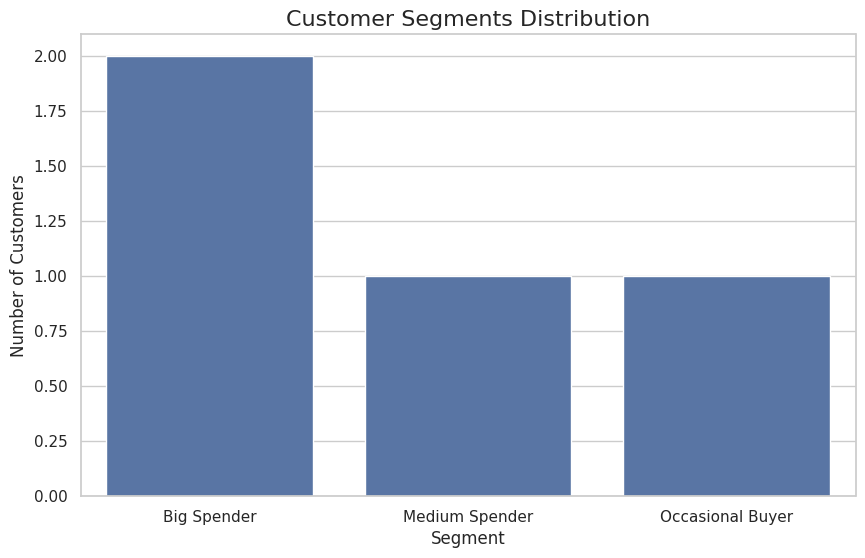

In [ ]:
# 📊 Visualizes results with matplotlib.

plt.figure(figsize=(10, 6))
sns.countplot(data=seg_df, x='segment', order=['Big Spender', 'Medium Spender', 'Occasional Buyer'])
plt.title('Customer Segments Distribution', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.show()


<a id="groupconcat"></a>

## ✅ GROUP_CONCAT — Aggregating Strings


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>For each customer, list purchased **products in one row**.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>CTE first to make lists **ordered & distinct**, then `GROUP_CONCAT`.
</div>


#### 🔍 Deep Dive

- CTEs split the logic into named steps so the final SELECT stays readable.
- GROUP_CONCAT: add ORDER BY inside the function for deterministic ordering; use DISTINCT to de-dup.
- Aggregation: every selected column must be aggregated or appear in GROUP BY (SQLite is strict here).
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.

In [ ]:

q("""-- 💡 Using CTEs to break complex logic into steps.
-- 🧵 GROUP_CONCAT: consider DISTINCT/ORDER BY -- final sort / tie-break inside to control duplicates and order.
-- First, create a CTE to get a unique, sorted list of products for each customer.
WITH unique_products_per_customer AS (
  -- DISTINCT ensures we don't list the same product multiple times if bought repeatedly.
  -- ORDER BY -- final sort / tie-break ensures the list will be alphabetical.
  SELECT DISTINCT customer_id, product
  FROM -- source tables/CTEs purchases
  ORDER BY -- final sort / tie-break customer_id, product
)
-- Now, aggregate the products FROM -- source tables/CTEs the CTE.
SELECT
  customer_id,
  -- GROUP_CONCAT joins the 'product' strings for each customer, separated by ', '.
  GROUP_CONCAT(product, ', ') AS products
FROM -- source tables/CTEs unique_products_per_customer
GROUP BY -- aggregate rows into groups customer_id
ORDER BY -- final sort / tie-break customer_id;
""")


,customer_id,products
0,1,"Laptop, Mouse, USB-C Hub"
1,2,"Case, Tablet"
2,3,"Book, Notebook, Pen"
3,4,"Enterprise Support, Server"


<div style="padding:12px 14px;border-left:6px solid #6a1b9a;background:#f3e5f5;border-radius:8px;margin:10px 0;">
<b>Pro Tip: Cross-Dialect Compatibility</b><br>While `GROUP_CONCAT` is specific to SQLite and MySQL, other databases use the ANSI standard `STRING_AGG(product, ', ')`. For instance, in PostgreSQL or SQL Server, you would use `STRING_AGG` to achieve the same result.
</div>

<a id="strftime"></a>

## ✅ strftime — Bucketing by Month


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Count **orders per month**.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>`strftime('%Y-%m', date)` extracts **year-month** in SQLite. In Postgres/Snowflake use `DATE_TRUNC('month', date)`.
</div>


#### 🔍 Deep Dive

- CTEs split the logic into named steps so the final SELECT stays readable.
- Aggregation: every selected column must be aggregated or appear in GROUP BY (SQLite is strict here).
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.

In [ ]:

orders_by_month = q("""-- 💡 Using CTEs to break complex logic into steps.
SELECT
    -- strftime ('string format time') is a function that formats a date/time string.
    -- The first argument, '%Y-%m', is the format string:
    --   %Y is replaced by the 4-digit year.
    --   %m is replaced by the 2-digit month.
    -- This effectively "truncates" the date to the beginning of the month.
    strftime('%Y-%m', order_date) AS month,

    -- COUNT(*) is an aggregate function that counts the total number of rows
    -- for each group defined in the GROUP BY -- aggregate rows into groups clause.
    COUNT(*) AS total_orders
FROM -- source tables/CTEs
    orders
-- GROUP BY -- aggregate rows into groups month tells the database to collect all rows with the same 'month' value
-- (e.g., all rows for '2023-01') into a single group and then apply the aggregate function (COUNT).
GROUP BY -- aggregate rows into groups
    month
-- ORDER BY -- final sort / tie-break month sorts the final result set chronologically.
ORDER BY -- final sort / tie-break
    month;
"""); orders_by_month


,month,total_orders
0,2023-01,2
1,2023-02,2
2,2023-03,2


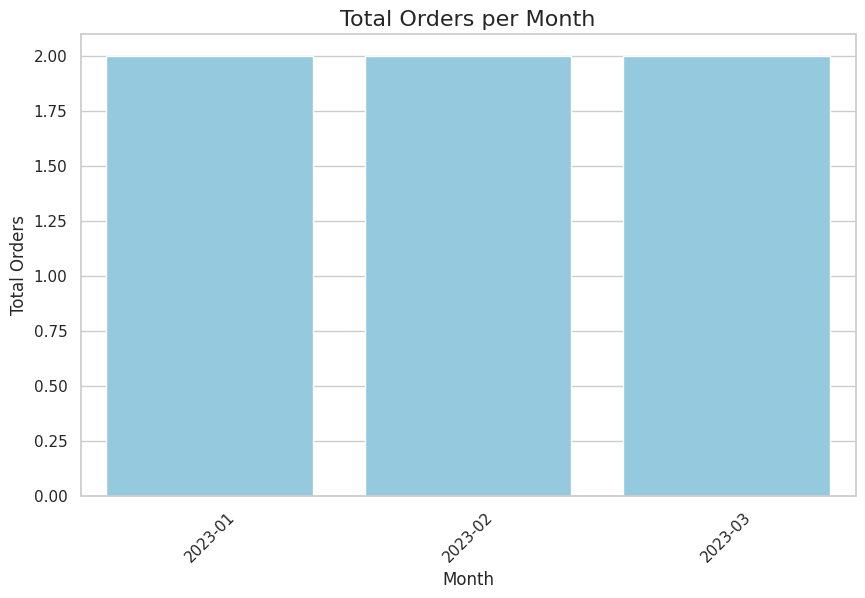

In [ ]:
# 📊 Visualizes results with matplotlib.

plt.figure(figsize=(10, 6))
sns.barplot(data=orders_by_month, x='month', y='total_orders', color='skyblue')
plt.title('Total Orders per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Orders', fontsize=12)
plt.xticks(rotation=45)
plt.show()


<a id="windows"></a>

## ✅ Window Functions — Top‑N per Group


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Get the **latest** per user, or **top‑N** events per user.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>`ROW_NUMBER() OVER (PARTITION BY user ORDER BY ts DESC)` numbers rows **inside each user window**.
</div>


#### 🔍 Deep Dive

- Capstone: composes earlier patterns (CTEs + segmentation + windows) to answer a realistic product/customer question.
- Ranks items per customer to get 'latest' or 'top‑N' consistently.
- CTEs split the logic into named steps so the final SELECT stays readable.
- Window functions: ensure PARTITION BY matches the grouping you intend; specify ORDER BY for stable rank.
- ROW_NUMBER tie-breakers: include a secondary ORDER BY key so results are deterministic.
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.
- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

**Executive Summary:**

This report stitches together everything we’ve built — cleaned contacts, ranked purchases, and clear segments — to answer: Who are our customers, how should we think about them, and what have they most recently engaged with? It’s the single table a stakeholder can use to prioritize outreach and measure impact.

In [ ]:
# Get the single most recent activity for each user
q("""-- 💡 Using CTEs to break complex logic into steps.
-- 📊 Window functions: explicit ORDER BY -- final sort / tie-break + frame for correctness and determinism.
-- Use a CTE to rank activities for each user.
WITH ranked_activities AS (
  SELECT
    user_id,
    activity_date,
    -- ROW_NUMBER() assigns a unique, sequential integer to each row.
    -- OVER (...) defines the 'window' for the function.
    -- PARTITION BY -- window grouping boundary user_id: The ranking restarts for each new user.
    -- ORDER BY activity_date DESC: Within each user's window, rows are ordered FROM -- source tables/CTEs newest to oldest.
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY -- final sort / tie-break activity_date DESC) AS rn
  FROM -- source tables/CTEs user_activities
)
-- Select only the rows WHERE -- pre-aggregation filters the rank (rn) is 1 (the most recent).
SELECT user_id, activity_date
FROM -- source tables/CTEs ranked_activities
WHERE -- pre-aggregation filters rn = 1
ORDER BY -- final sort / tie-break user_id;
""")


#### 🧭 Interpreting the Capstone Output
- **What you’re seeing:** a customer‑level rollup that merges cleaned contact info, purchase rankings, and segment labels.
- **Why these rows appear:** the final CTE keeps all customers (LEFT JOIN); customers without qualifying purchases show placeholders.
- **Top‑N logic:** products are ranked per customer with a window function; the final SELECT filters to the top‑N (e.g., latest two) before aggregating.
- **Segmentation:** `CASE` labels (e.g., `VIP`, `Occasional`) are assigned based on thresholds. First matching `WHEN` wins.
- **Sanity checks:**
  - Count rows per segment to ensure thresholds produce expected distributions.
  - Spot‑check a few customers to confirm the ranked products match their true recency.
- **Business readout:** this table answers “Who are my customers, how should I think about them, and what have they most recently engaged with?”

<a id="yourturn"></a>

## ✍️ Your Turn: Oldest Purchases

<div style="padding:12px 14px;border-left:6px solid #ef6c00;background:#fff3e0;border-radius:8px;margin:10px 0;">
<b>Challenge</b><br>Using what you learned about window functions, write a query to find the **two oldest purchases** for each customer. Display the customer ID, product, and purchase timestamp.
</div>

#### 🔍 Deep Dive

- Capstone: composes earlier patterns (CTEs + segmentation + windows) to answer a realistic product/customer question.
- Ranks items per customer to get 'latest' or 'top‑N' consistently.
- CTEs split the logic into named steps so the final SELECT stays readable.
- Window functions: ensure PARTITION BY matches the grouping you intend; specify ORDER BY for stable rank.
- ROW_NUMBER tie-breakers: include a secondary ORDER BY key so results are deterministic.
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.
- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

**Executive Summary:**

This report stitches together everything we’ve built — cleaned contacts, ranked purchases, and clear segments — to answer: Who are our customers, how should we think about them, and what have they most recently engaged with? It’s the single table a stakeholder can use to prioritize outreach and measure impact.

In [ ]:
# Your solution here!
# Hint: You'll need to PARTITION BY customer_id and ORDER BY purchase_ts ASC.
q("""-- 💡 Using CTEs to break complex logic into steps.
-- 📊 Window functions: explicit ORDER BY -- final sort / tie-break + frame for correctness and determinism.
-- Solution for the challenge
WITH ranked_purchases AS (
  SELECT
    customer_id,
    product,
    purchase_ts,
    ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY -- final sort / tie-break purchase_ts ASC) as rn_asc
  FROM -- source tables/CTEs purchases
)
SELECT customer_id, product, purchase_ts
FROM -- source tables/CTEs ranked_purchases
WHERE -- pre-aggregation filters rn_asc <= 2
ORDER BY -- final sort / tie-break customer_id, purchase_ts;
""")

<a id="ties"></a>

## ✅ Handling Ties — `RANK` vs `DENSE_RANK`


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Understand which ranking to use when **timestamps tie**.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>`RANK` leaves gaps after ties (1,1,3); `DENSE_RANK` does not (1,1,2). `ROW_NUMBER` always increments.
</div>


#### 🔍 Deep Dive

- Capstone: composes earlier patterns (CTEs + segmentation + windows) to answer a realistic product/customer question.
- Ranks items per customer to get 'latest' or 'top‑N' consistently.
- CTEs split the logic into named steps so the final SELECT stays readable.
- Window functions: ensure PARTITION BY matches the grouping you intend; specify ORDER BY for stable rank.
- ROW_NUMBER tie-breakers: include a secondary ORDER BY key so results are deterministic.
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.
- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

**Executive Summary:**

This report stitches together everything we’ve built — cleaned contacts, ranked purchases, and clear segments — to answer: Who are our customers, how should we think about them, and what have they most recently engaged with? It’s the single table a stakeholder can use to prioritize outreach and measure impact.

#### 🔍 Deep Dive — RANK vs DENSE_RANK (Top‑N per Group)

- **Purpose:** assign positions within each group using `OVER (PARTITION BY ...) ORDER BY ...`.
- **RANK():** leaves gaps after ties (1,1,3). Reflects competitive placing.
- **DENSE_RANK():** no gaps after ties (1,1,2). Great for compact Top‑N filters.
- **Tie‑breaking:** add a secondary `ORDER BY` column for determinism.
- **Top‑N per group:** wrap in a CTE, then `WHERE rnk <= N`.
- **QA tip:** count rows per rank to ensure expected distribution and check for duplicates.

> **Example QA snippet**: ensure deterministic ranking
>
> ```sql
> SELECT customer_id, score, ts,
>        RANK() OVER (PARTITION BY customer_id ORDER BY score DESC, ts DESC) AS rnk
> FROM scores;
> ```

**Why this matters (Business Question):**

_Who are the top N items per group (e.g., top 3 products per customer), and how do we treat ties fairly?_ RANK and DENSE_RANK answer leaderboard‑style questions with transparent tie handling.

### 🎯 Toy Dataset — Visualizing Ties for RANK() vs DENSE_RANK()
This mini‑dataset intentionally creates ties so you can see how `RANK()` and `DENSE_RANK()` behave differently.

In [ ]:
# 🗄️ Create a toy table with intentional ties in score per group
conn.execute('DROP TABLE IF EXISTS scores;')
conn.execute('''
CREATE TABLE scores (
    customer_id INTEGER,
    score INTEGER,
    ts TEXT
);
''')

# Insert rows with ties (same score) per customer
rows = [
    (1, 100, '2025-01-01'),
    (1, 100, '2025-01-02'),
    (1,  95, '2025-01-03'),
    (2,  88, '2025-01-01'),
    (2,  88, '2025-01-02'),
    (2,  85, '2025-01-03')
]
conn.executemany('INSERT INTO scores VALUES (?, ?, ?);', rows)
conn.commit()
print('Sample scores table created.')

In [ ]:
# 🏁 Compare RANK() vs DENSE_RANK() side-by-side
q('''
SELECT customer_id, score, ts,
       RANK() OVER (
           PARTITION BY customer_id  -- group per customer
           ORDER BY score DESC, ts DESC  -- tie-break by date
       ) AS rnk,
       DENSE_RANK() OVER (
           PARTITION BY customer_id
           ORDER BY score DESC, ts DESC
       ) AS dense_rnk
FROM scores
ORDER BY customer_id, rnk;
''')

#### 📊 Interpreting the Output
- **Customer 1:** The first two rows have the same score (`100`) so they both get `RANK=1` and `DENSE_RANK=1`.
  - For `RANK()`, the next score (`95`) jumps to `3` (gap after tie).
  - For `DENSE_RANK()`, the next score is `2` (no gap).
- **Customer 2:** Same pattern — ties for `88` get `1` in both functions, but the next score (`85`) is `3` for `RANK()` and `2` for `DENSE_RANK()`.
- **Takeaway:** Use `RANK()` when the *relative position* matters (like race standings), and `DENSE_RANK()` when you need *compact sequences* for filtering or reporting.
- **QA Tip:** Always check if the tie-break `ORDER BY` produces consistent results, especially when two rows have identical values in the main sort key.

In [ ]:
# 🏁 Demonstrates RANK vs DENSE_RANK and Top‑N per group with deterministic tie‑breaks.

cur.execute("INSERT OR IGNORE INTO user_activities (user_id, activity_date) VALUES (1, '2023-08-05')"); conn.commit()
q("""-- 🏁 RANK vs DENSE_RANK: assigns positions within each PARTITION (group).
--     • RANK: leaves gaps after ties (1,1,3)
--     • DENSE_RANK: no gaps after ties (1,1,2)
-- 🔒 Determinism: add a secondary ORDER BY -- rank order; add secondary key to break ties key to break ties consistently.
-- 🧱 Top‑N pattern: compute rank in a CTE/subquery, then WHERE rank_col <= N.
-- 💡 Using CTEs to break complex logic into steps.
-- 📊 Window functions: explicit ORDER BY -- final sort / tie-break + frame for correctness and determinism.
-- Select all three ranking functions to see how they behave with ties.
SELECT
  user_id,
  activity_date,

  -- ROW_NUMBER: Always assigns a unique, sequential number (1, 2, 3, 4...) within the partition.
  -- It arbitrarily breaks ties. Useful when you need exactly N rows and don't care about ties.
  ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY -- final sort / tie-break activity_date DESC) AS row_number,

  -- RANK: Assigns the same rank to tied rows. After a tie, it skips the next rank(s).
  -- Example: If two rows tie for 1st place, they both get rank 1, and the next row gets rank 3.
  -- Useful for "Top 10" lists WHERE -- pre-aggregation filters ties share a position.
  RANK() -- gaps after ties       OVER (PARTITION BY user_id ORDER BY -- final sort / tie-break activity_date DESC) AS rank_val,

  -- DENSE_RANK: Also assigns the same rank to tied rows, but does NOT skip ranks.
  -- Example: If two rows tie for 1st, they both get rank 1, and the next row gets rank 2.
  -- Useful when you want to rank items without gaps in the sequence.
  DENSE_RANK() -- no gaps after ties OVER (PARTITION BY user_id ORDER BY -- final sort / tie-break activity_date DESC) AS dense_rank

FROM -- source tables/CTEs
  user_activities
-- The final ORDER BY -- final sort / tie-break clause sorts the entire result set for clear presentation.
ORDER BY -- final sort / tie-break
  user_id, activity_date DESC;
""")


<a id="nested"></a>

## ✅ Nested CASE — Multi-dimensional Segmentation

**Business Question:**

_How do we label customers in a way that reflects value and behavior so downstream teams can act?_

**Goal / How it works**

- **Goal:** Assign mutually exclusive, business-meaningful segments.
- **How it works:** Ordered `CASE WHEN` blocks; first match wins; final `ELSE` for coverage.

**Executive Summary:**

We move beyond simple spend totals to identify our true power users. By combining purchase value with product variety and frequency, we define a “VIP Multi‑Buyer” segment — a core group of customers who purchase broadly and often. These segments turn raw metrics into labels that product and marketing can act on.

> **Tip:** In nested CASE blocks, order your WHEN clauses from most‑specific to least‑specific.
>
> Add a final `ELSE` to capture uncategorized rows, and run a QA query (COUNT by segment) to confirm exclusivity and coverage.


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Give **VIP** treatment to high spenders; upgrade to **VIP Multi‑Buyer** with product breadth.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>Compute **product_count** in a CTE; only check breadth for big spenders (nested CASE).
</div>


#### 🔍 Deep Dive

- CTEs split the logic into named steps so the final SELECT stays readable.
- JOIN strategy: verify join keys and decide INNER vs LEFT based on whether you want to keep unmatched rows.
- Nested CASE: evaluates conditions in order; first match wins. Place most-specific conditions first.
- Aggregation: every selected column must be aggregated or appear in GROUP BY (SQLite is strict here).
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.

In [ ]:
nested_seg_df = q("""-- 💡 Using CTEs to break complex logic into steps.
-- 🔗 JOIN -- combine tables on keys (check cardinality) keys matter: confirm cardinality and expected row counts.
-- 🧩 Nested CASE -- conditional logic (first matching WHEN wins): ordered evaluation; most-specific first to avoid accidental matches.
-- First CTE: Count the number of unique products per customer.
WITH product_counts AS (
  SELECT customer_id, COUNT(DISTINCT product) AS product_count
  FROM -- source tables/CTEs purchases
  GROUP BY -- aggregate rows into groups customer_id
)
-- Main query to JOIN -- combine tables on keys (check cardinality) transaction data with product counts and apply nested logic.
SELECT
  t.customer_id,
  t.purchase_amount,
  pc.product_count,
  -- Outer CASE -- conditional logic (first matching WHEN wins) checks the purchase amount.
  CASE -- conditional logic (first matching WHEN wins)
    WHEN t.purchase_amount > 500 THEN
      -- Inner (nested) CASE -- conditional logic (first matching WHEN wins) checks product count ONLY for big spenders.
      CASE -- conditional logic (first matching WHEN wins)
        WHEN pc.product_count >= 2 THEN 'VIP Multi-Buyer'
        ELSE 'VIP'
      END
    WHEN t.purchase_amount > 100 THEN 'Engaged'
    ELSE 'Occasional'
  END AS nested_segment
FROM -- source tables/CTEs transactions t
LEFT JOIN -- combine tables on keys (check cardinality) product_counts pc ON pc.customer_id = t.customer_id
ORDER BY -- final sort / tie-break t.customer_id;
""")
nested_seg_df

### Insightful Visualization: Spend vs. Breadth

In [ ]:
# 📊 Visualizes results with matplotlib.
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=nested_seg_df,
    x='purchase_amount',
    y='product_count',
    hue='nested_segment',
    s=200, # size of points
    alpha=0.8,
    palette='viridis' # color scheme
)
plt.title('Customer Segmentation by Spend and Product Count', fontsize=16)
plt.xlabel('Total Purchase Amount ($)', fontsize=12)
plt.ylabel('Number of Unique Products', fontsize=12)
plt.legend(title='Customer Segment')
plt.show()

<a id="performance"></a>

## 🚀 Performance Tuning — `EXPLAIN QUERY PLAN`

<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Understand how the database executes a query and learn how to make it faster using an **index**.
</div>

<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>`EXPLAIN QUERY PLAN` shows the database's strategy. A `SCAN` means it reads the whole table, which is slow. An `INDEX` is a special lookup table that the database can use to find rows quickly, resulting in a much faster `SEARCH`.
</div>

In [ ]:
# Without an index, the database must SCAN the entire 'purchases' table.
q("EXPLAIN QUERY PLAN SELECT * FROM purchases WHERE customer_id = 2;")

In [ ]:
# 📈 Runs a SQL query and displays/prints the resulting DataFrame.
# Let's create an index on the column we are querying.
cur.execute("CREATE INDEX IF NOT EXISTS idx_purchases_customer_id ON purchases(customer_id);");
conn.commit()
print("Index 'idx_purchases_customer_id' created.")

In [ ]:
# Now, it uses the index for a fast SEARCH instead of a slow SCAN.
q("EXPLAIN QUERY PLAN SELECT * FROM purchases WHERE customer_id = 2;")

<a id="capstone"></a>

## 🚀 Capstone — The Final Report

**Executive Summary:**

This report stitches together everything we’ve built — cleaned contacts, ranked purchases, and clear segments — to answer: Who are our customers, how should we think about them, and what have they most recently engaged with? It’s the single table a stakeholder can use to prioritize outreach and measure impact.


<div style="padding:12px 14px;border-left:6px solid #2e7d32;background:#e8f5e9;border-radius:8px;margin:10px 0;">
<b>Goal</b><br>Produce a **final customer report** with cleaned email, segment, and their **two most recent** products.
</div>



<div style="padding:12px 14px;border-left:6px solid #1565c0;background:#e3f2fd;border-radius:8px;margin:10px 0;">
<b>How it works</b><br>Combine all our superpowers! Use CTEs to **clean data first**, rank products, create segments, and aggregate product lists before **joining everything together** for a clean, scalable final query.
</div>


#### 🔍 Deep Dive

- Capstone: composes earlier patterns (CTEs + segmentation + windows) to answer a realistic product/customer question.
- Builds in phases using multiple CTEs; each CTE isolates a concern (contacts, purchases, rankings).
- Ranks items per customer to get 'latest' or 'top‑N' consistently.
- Rolls up detail rows into readable summaries per customer with GROUP_CONCAT.
- Segments customers/products with CASE to produce analyst‑friendly categories.
- CTEs split the logic into named steps so the final SELECT stays readable.
- JOIN strategy: verify join keys and decide INNER vs LEFT based on whether you want to keep unmatched rows.
- Nested CASE: evaluates conditions in order; first match wins. Place most-specific conditions first.
- GROUP_CONCAT: add ORDER BY inside the function for deterministic ordering; use DISTINCT to de-dup.
- Window functions: ensure PARTITION BY matches the grouping you intend; specify ORDER BY for stable rank.
- ROW_NUMBER tie-breakers: include a secondary ORDER BY key so results are deterministic.
- Aggregation: every selected column must be aggregated or appear in GROUP BY (SQLite is strict here).
- ORDER BY at the outermost level defines final presentation; inner ORDER BYs only affect subqueries/aggregates that read them.
- WHERE filters before aggregation; use HAVING to filter after GROUP BY.

In [ ]:

q("""-- 💡 Using CTEs to break complex logic into steps.
-- 🔗 JOIN -- combine tables on keys (check cardinality) keys matter: confirm cardinality and expected row counts.
-- 🧩 Nested CASE -- conditional logic (first matching WHEN wins): ordered evaluation; most-specific first to avoid accidental matches.
-- 📊 Window functions: explicit ORDER BY -- final sort / tie-break + frame for correctness and determinism.
-- 🧵 GROUP_CONCAT: consider DISTINCT/ORDER BY -- final sort / tie-break inside to control duplicates and order.
-- This query is broken into multiple Common Table Expressions (CTEs) for clarity and modularity.
-- Each CTE performs a distinct step in the data transformation process.

-- CTE 1: Clean the customer data.
WITH cleaned_customers AS (
  SELECT
    id,
    name,
    -- Use our COALESCE/NULLIF/TRIM pattern to find the best available email and clean it.
    COALESCE(NULLIF(TRIM(email), ''), NULLIF(TRIM(backup_email), ''), 'noemail@example.com') AS best_email
  FROM -- source tables/CTEs customers
),

-- CTE 2: Calculate product breadth for each customer.
product_counts AS (
  SELECT
    customer_id,
    -- COUNT(DISTINCT ...) ensures we only count each unique product once per customer.
    COUNT(DISTINCT product) AS product_count
  FROM -- source tables/CTEs purchases
  GROUP BY -- aggregate rows into groups customer_id
),

-- CTE 3: Create the customer segments using the nested CASE -- conditional logic (first matching WHEN wins) logic.
segments AS (
  SELECT
    t.customer_id,
    CASE -- conditional logic (first matching WHEN wins)
      WHEN t.purchase_amount > 500 THEN
        CASE -- conditional logic (first matching WHEN wins) WHEN pc.product_count >= 2 THEN 'VIP Multi-Buyer' ELSE 'VIP' END
      WHEN t.purchase_amount > 100 THEN 'Engaged'
      ELSE 'Occasional'
    END AS segment
  -- JOIN -- combine tables on keys (check cardinality) transactions with our product counts to use both metrics in the CASE -- conditional logic (first matching WHEN wins) statement.
  FROM -- source tables/CTEs transactions t
  LEFT JOIN -- combine tables on keys (check cardinality) product_counts pc ON pc.customer_id = t.customer_id
),

-- CTE 4: Rank all products for each customer FROM -- source tables/CTEs newest to oldest.
ranked_products AS (
  SELECT
    customer_id,
    product,
    purchase_ts,
    -- Use ROW_NUMBER to assign a rank within each customer's partition, ordered by date.
    ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY -- final sort / tie-break purchase_ts DESC) AS rn
  -- The subquery with DISTINCT handles cases WHERE -- pre-aggregation filters a customer might buy the same product on the same day.
  FROM -- source tables/CTEs (SELECT DISTINCT customer_id, product, purchase_ts FROM -- source tables/CTEs purchases)
),

-- CTE 5: Create the final comma-separated list of the top 2 products.
top_products_list AS (
  SELECT
    customer_id,
    -- Filter for the top 2 ranked products, then aggregate them into a string.
    GROUP_CONCAT(product, ', ') AS last_two_products
  FROM -- source tables/CTEs ranked_products
  WHERE -- pre-aggregation filters rn <= 2
  GROUP BY -- aggregate rows into groups customer_id
)

-- Final SELECT: Assemble the report by joining all the CTEs.
SELECT
  c.name,
  c.best_email,
  s.segment,
  tpl.last_two_products
FROM -- source tables/CTEs cleaned_customers c
-- Use an INNER JOIN -- combine tables on keys (check cardinality) for segments because every customer must have a segment.
JOIN -- combine tables on keys (check cardinality) segments s ON s.customer_id = c.id
-- Use a LEFT JOIN -- combine tables on keys (check cardinality) for the product list, as a customer might not have any products.
LEFT JOIN -- combine tables on keys (check cardinality) top_products_list tpl ON tpl.customer_id = c.id
ORDER BY -- final sort / tie-break c.name;
""")


### 🧪 Data Quality & Validation — Constraints + Programmatic Checks
**Database constraints** prevent bad data from entering. **Assertions** and QA queries catch issues early in your pipeline.

**Example:** Create a small `transactions` table with a `CHECK` constraint preventing negative amounts.
Then run a QA query and assert basic expectations.


In [ ]:
# 🔒 Example: CHECK constraint + QA
conn.execute('DROP TABLE IF EXISTS transactions;')
conn.execute('''
CREATE TABLE transactions (
    id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    purchase_amount REAL,
    CHECK(purchase_amount >= 0)
);
''')
conn.executemany('INSERT INTO transactions (customer_id, purchase_amount) VALUES (?, ?);', [
    (1, 19.99), (1, 0.00), (2, 5.50)
])
conn.commit()

# QA query: verify no negative amounts and totals > 0 for customers who appear
qa_df = q('''
SELECT customer_id, COUNT(*) AS n, SUM(purchase_amount) AS total_amt,
       SUM(CASE WHEN purchase_amount < 0 THEN 1 ELSE 0 END) AS negatives
FROM transactions
GROUP BY customer_id
ORDER BY customer_id;
''')

print(qa_df)
assert qa_df['negatives'].sum() == 0, 'Found negative amounts despite CHECK constraint.'
assert (qa_df['total_amt'] >= 0).all(), 'Totals should be non-negative.'
print('✅ Data quality checks passed.')


### 🎮 Interactive Customer Report Dashboard
**Purpose:** Let non‑technical users explore the final report by selecting a customer.

**How it works:** A dropdown drives the capstone query filtered by the chosen customer.

In [ ]:
# 📊 Interactive Customer Report
import ipywidgets as widgets
from IPython.display import display, clear_output

customer_list = q("SELECT name FROM customers ORDER BY name;")['name'].tolist()
dropdown = widgets.Dropdown(options=customer_list, description='Customer:')
output_area = widgets.Output()

def generate_customer_report(customer_name):
    report_sql = """
    -- TODO: replace the CTEs below with your actual capstone CTE names
    WITH cleaned_customers AS (
        SELECT id, name, best_email FROM customers
    ),
    segments AS (
        SELECT customer_id, segment FROM customer_segments
    ),
    top_products_list AS (
        SELECT customer_id, GROUP_CONCAT(product, ', ') AS last_two_products
        FROM top_products
        GROUP BY customer_id
    )
    SELECT c.name, c.best_email, s.segment, tpl.last_two_products
    FROM cleaned_customers c
    JOIN segments s ON s.customer_id = c.id
    LEFT JOIN top_products_list tpl ON tpl.customer_id = c.id
    WHERE c.name = ?;
    """
    return q(report_sql, params=[customer_name])

def on_customer_change(change):
    with output_area:
        clear_output(wait=True)
        selected_customer = change.new
        print(f"--- Report for: {selected_customer} ---")
        report_df = generate_customer_report(selected_customer)
        display(report_df)

dropdown.observe(on_customer_change, names='value')
display(dropdown, output_area)
if customer_list:
    on_customer_change({'new': customer_list[0]})


### 🏆 Your Final Challenge: Identify At‑Risk VIPs
**Task:** Modify the Capstone query to create a report of customers labeled `VIP` / `VIP Multi-Buyer` who **did not** make a purchase in 2023.
- Compute each customer’s most recent purchase date.
- Filter to VIP segments.
- Return the customers who have a max purchase date < '2023‑01‑01' (or `NULL`).

> **Hint:** Use a CTE to compute `MAX(purchase_ts)` per customer and join it back to the segmentation.


**Executive Summary:**

This report stitches together everything we’ve built — cleaned contacts, ranked purchases, and clear segments — to answer: Who are our customers, how should we think about them, and what have they most recently engaged with? It’s the single table a stakeholder can use to prioritize outreach and measure impact.

<details>
<summary><strong>✅ Solution Key (click to expand)</strong></summary>

**Goal:** Identify customers labeled `VIP` or `VIP Multi-Buyer` who did not make a purchase in 2023.

**Two ways to solve:**
1) **Use your existing segmentation output** (recommended) if your capstone already produces a `segment` per customer.
2) **Fallback segmentation** (below) if you want a self-contained example based on purchase counts.

---

### Option A — If your capstone already has segments
```sql
-- Replace `customer_segments` with the name of your capstone output that has (customer_id, segment)
WITH last_purchase AS (
  SELECT customer_id, MAX(purchase_ts) AS max_purchase_ts
  FROM purchases
  GROUP BY customer_id
)
SELECT c.id, c.name, s.segment, lp.max_purchase_ts
FROM customers c
JOIN customer_segments s ON s.customer_id = c.id
LEFT JOIN last_purchase lp ON lp.customer_id = c.id
WHERE s.segment IN ('VIP', 'VIP Multi-Buyer')
  AND (lp.max_purchase_ts IS NULL OR lp.max_purchase_ts < '2023-01-01')
ORDER BY c.name;
```

---

### Option B — Fallback segmentation by purchase count (runnable)
The runnable cell below labels:
- `VIP Multi-Buyer` if a customer has **5+** purchases total,
- `VIP` if a customer has **2–4** purchases,
- otherwise `Other`.
</details>

In [ ]:
# 🧩 Option B — Runnable fallback segmentation + at‑risk filter
q('''
WITH purchase_counts AS (
  SELECT c.id AS customer_id,
         c.name,
         COUNT(p.id) AS n_purchases
  FROM customers c
  LEFT JOIN purchases p ON p.customer_id = c.id
  GROUP BY c.id, c.name
),
segments AS (
  SELECT customer_id,
         name,
         CASE
           WHEN n_purchases >= 5 THEN 'VIP Multi-Buyer'
           WHEN n_purchases BETWEEN 2 AND 4 THEN 'VIP'
           ELSE 'Other'
         END AS segment
  FROM purchase_counts
),
last_purchase AS (
  SELECT customer_id, MAX(purchase_ts) AS max_purchase_ts
  FROM purchases
  GROUP BY customer_id
)
SELECT s.customer_id, s.name, s.segment, lp.max_purchase_ts
FROM segments s
LEFT JOIN last_purchase lp ON lp.customer_id = s.customer_id
WHERE s.segment IN ('VIP', 'VIP Multi-Buyer')
  AND (lp.max_purchase_ts IS NULL OR lp.max_purchase_ts < '2023-01-01')
ORDER BY s.name;
''')


### 🏆 Final Predictive Challenge — Potential VIPs
**Executive Summary:** Identify customers on the verge of VIP status so marketing can engage them early.

**Business Question:** Who is likely to become a VIP next?

**Criteria:**
1) Current segment is `Engaged`.
2) Has purchased **3+ unique products**.
3) **Average time between purchases** < 30 days.

**Goal / How it works**

- **Goal:** Flag `Potential VIP` customers.
- **How it works:** Use CTEs to compute product breadth (`COUNT(DISTINCT product)`), purchase gaps via `LAG()`, and average gap per customer; filter engaged customers meeting all thresholds.

In [ ]:
# 🧠 Template: compute Potential VIPs per criteria
q('''
WITH engaged AS (
  SELECT customer_id FROM customer_segments WHERE segment = 'Engaged'
),
product_breadth AS (
  SELECT customer_id, COUNT(DISTINCT product) AS unique_products
  FROM purchases
  GROUP BY customer_id
),
gaps AS (
  SELECT customer_id,
         purchase_ts,
         LAG(purchase_ts) OVER (PARTITION BY customer_id ORDER BY purchase_ts) AS prev_ts
  FROM purchases
),
avg_gap AS (
  SELECT customer_id,
         AVG(julianday(purchase_ts) - julianday(prev_ts)) AS avg_days_between
  FROM gaps
  WHERE prev_ts IS NOT NULL
  GROUP BY customer_id
)
SELECT c.id, c.name,
       pb.unique_products,
       ag.avg_days_between
FROM customers c
JOIN engaged e ON e.customer_id = c.id
LEFT JOIN product_breadth pb ON pb.customer_id = c.id
LEFT JOIN avg_gap ag ON ag.customer_id = c.id
WHERE COALESCE(pb.unique_products, 0) >= 3
  AND COALESCE(ag.avg_days_between, 9999) < 30
ORDER BY c.name;
''')


### 🎮 Interactive Customer Report Dashboard

**Purpose:** Explore the capstone result per customer.


In [ ]:
# 📊 Interactive Customer Report (wired to Capstone)
import ipywidgets as widgets
from IPython.display import display, clear_output

customer_list = q("SELECT name FROM customers ORDER BY name;")['name'].tolist()
dd = widgets.Dropdown(options=customer_list, description='Customer:')
out = widgets.Output()

CAPSTONE_SQL = """

WITH ordered_purchases AS (
  SELECT
    customer_id,
    purchase_ts,
    LAG(purchase_ts, 1) OVER (
      PARTITION BY customer_id
      ORDER BY purchase_ts
    ) AS prev_purchase_ts
  FROM purchases
)
SELECT
  customer_id,
  prev_purchase_ts,
  purchase_ts,
  ROUND(julianday(purchase_ts) - julianday(prev_purchase_ts), 2) AS days_between
FROM ordered_purchases
WHERE prev_purchase_ts IS NOT NULL
ORDER BY customer_id, purchase_ts;

"""

def show_customer(name):
    with out:
        clear_output(wait=True)
        df = q(CAPSTONE_SQL, params=[name])
        display(df)

dd.observe(lambda ch: show_customer(ch['new']), names='value')
display(dd, out)
if customer_list:
    show_customer(customer_list[0])


In [ ]:
# 🧰 Analytics Toolkit — Reusable helper
def find_potential_vips(min_products=3, max_avg_days=30):
    """
    Identifies 'Engaged' customers who show signs of becoming VIPs.
    Args:
        min_products: Minimum number of unique products.
        max_avg_days: Maximum average days between purchases.
    """
    sql = """
    WITH engaged AS (
      SELECT customer_id FROM customer_segments WHERE segment = 'Engaged'
    ),
    product_breadth AS (
      SELECT customer_id, COUNT(DISTINCT product) AS unique_products
      FROM purchases
      GROUP BY customer_id
    ),
    gaps AS (
      SELECT customer_id,
             purchase_ts,
             LAG(purchase_ts) OVER (PARTITION BY customer_id ORDER BY purchase_ts) AS prev_ts
      FROM purchases
    ),
    avg_gap AS (
      SELECT customer_id,
             AVG(julianday(purchase_ts) - julianday(prev_ts)) AS avg_days_between
      FROM gaps
      WHERE prev_ts IS NOT NULL
      GROUP BY customer_id
    )
    SELECT c.id, c.name,
           pb.unique_products,
           ag.avg_days_between
    FROM customers c
    JOIN engaged e ON e.customer_id = c.id
    LEFT JOIN product_breadth pb ON pb.customer_id = c.id
    LEFT JOIN avg_gap ag ON ag.customer_id = c.id
    WHERE COALESCE(pb.unique_products, 0) >= ?
      AND COALESCE(ag.avg_days_between, 9999) < ?
    ORDER BY c.name;
    """
    df = q(sql, params=[min_products, max_avg_days])
    print(f"Found {len(df)} potential VIPs (≥{min_products} products, <{max_avg_days} days avg gap).")
    return df

# Example usage
try:
    display(find_potential_vips(2, 45))
except Exception as e:
    print('Note: run after seeding tables and segmentation.')


## 💡 Summary of Insights & Next Steps

**Key Insights:**
- A small cohort of **VIP Multi‑Buyers** drives outsized value via frequent and diverse purchases — primary targets for loyalty rewards.
- **Purchase frequency** is a strong loyalty signal: top users average < 30 days between purchases. Use this as a benchmark for campaigns.
- We identified **Potential VIPs** who already show strong engagement patterns but aren’t yet top spenders — ideal for nurture programs.

**Next Steps:**
1. Launch a loyalty program for current VIPs (benefits + early access).
2. Run a “fast track” promotion for Potential VIPs to increase cadence and variety.
3. Review segmentation thresholds quarterly and retrain the predictive criteria as behavior changes.


## ⏱️ Productionizing This Analysis
To keep insights fresh, schedule this notebook to run automatically:

- **Papermill**: Parameterize and execute notebooks via CLI.
- **Cloud Schedulers**: GCP Cloud Scheduler or AWS EventBridge can trigger runs weekly/monthly.
- **Airflow / Prefect**: Orchestrate notebook execution in your ETL, ensuring data freshness.
- **GitHub Actions**: For public/cloud data sources, schedule workflows to rebuild and publish the report.

**Tip:** Store parameter defaults (dates, thresholds) in one place so non-technical users can update them safely.

## 💡 Final Recommendations (Situation → Complication → Resolution)

**Situation:** Diverse customer base with varying engagement and spend.

**Complication:** Uniform treatment misses chances to retain top-value users and to grow promising ones; inconsistent data previously hindered reliable analysis.

**Resolution:** Clean, reliable segmentation and capstone reporting identify:
- **VIP Multi‑Buyers** — small, high-value cohort.
- **Potential VIPs** — strong engagement, poised to grow.

**Immediate Action:**
- Launch a loyalty program for VIPs.
- Run a targeted “fast track” campaign for Potential VIPs.

**Ongoing Strategy:**
- Schedule this notebook monthly; monitor segment shifts and campaign ROI.
- Review thresholds quarterly; evolve predictive criteria as behavior changes.